In [1]:
import os
import time
import multiprocessing as mp
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from botorch.utils.transforms import unnormalize, normalize

from proteus.inference.inference import infer_from_config
from objective import run_proteus, prot_builder

dtype = torch.double

os.chdir("..")
os.chdir("..")
os.chdir("..")

%matplotlib inline
%matplotlib widget

In [2]:
re_run = False # set to true if you want to create new grid of proteus runs for plotting

parameters = {"struct.mass_tot" : [0.7, 3.0],
              "struct.corefrac" : [0.3, 0.9]}

bounds = torch.tensor([[0.7, 0.3], [3.0, 0.9]], dtype=dtype)

true_pars = {"struct.mass_tot" : 2.,
             "struct.corefrac" : .6}
observe = ["R_obs", "H2O_vmr"]

ref = "input/demos/dummy.toml"
out = "infer_toy/"

true_obs = dict(run_proteus(parameters=true_pars, worker=0, iter=0, observables=observe, ref_config=ref, output=out))
true_obs

{'R_obs': np.float64(7965615.4204), 'H2O_vmr': np.float64(0.7073762847)}

In [3]:
f = prot_builder(parameters=parameters, observables=true_obs, worker=0, iter=0, ref_config=ref, output=out)

In [4]:
true_x = torch.tensor([[2., .6]], dtype=dtype)
true_x_norm = normalize(true_x, bounds)
f(true_x_norm)

tensor([[10.]], dtype=torch.float64)

In [5]:
builder_args =  dict(parameters=parameters,
                        observables=true_obs,
                        ref_config=ref,
                        output=out + "grid/")

def f_aug(x, iter, builder_args):
    f = prot_builder(
                    parameters=builder_args["parameters"],
                    observables=builder_args["observables"],
                    worker=-1,
                    iter=iter,
                    ref_config=builder_args["ref_config"],
                    output=builder_args["output"]
                    )

    return f(x)

n = 30
unit_grid = torch.linspace(0, 1, n, dtype=dtype)
X1, X2 = torch.meshgrid(unit_grid, unit_grid, indexing="ij") # each (n, n)
X = torch.stack([X1.flatten()[:, None], X2.flatten()[:, None]], dim=-1) # (n, 1, 2)

aug_args = [(x, i, builder_args) for i, x in enumerate(X)]

In [6]:
base = Path().resolve()  # folder that notebook is running from

if re_run:
    # this will take ~14 mins on an M3 MacBook
    avail_cpus = os.cpu_count() - 1
    t0 = time.perf_counter()
    ctx = mp.get_context("fork")
    with ctx.Pool(processes=avail_cpus) as pool:
        results = pool.starmap(f_aug, aug_args)
    t1 = time.perf_counter()
    Y = torch.vstack(results).reshape(n, n) # (n, n)
    torch.save(Y, base/"output/infer_toy/grid/Y.pt")
else:
    Y = torch.load(base/"output/infer_toy/grid/Y.pt")

In [7]:
print(Y.max())
idx = Y.argmax()
print(X[idx])
unnormalize(X[idx], bounds)

tensor(5.7365, dtype=torch.float64)
tensor([[0.5517, 0.4828]], dtype=torch.float64)


tensor([[1.9690, 0.5897]], dtype=torch.float64)

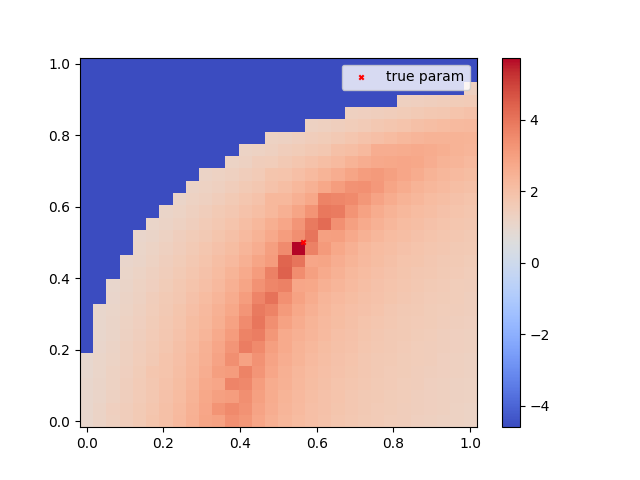

In [8]:
fig2d, ax2d = plt.subplots()
mesh = ax2d.pcolormesh(X1, X2, Y, shading="auto", cmap=cm.coolwarm)
fig2d.colorbar(mesh, ax=ax2d)
ax2d.scatter(true_x_norm[:, 0], true_x_norm[:, 1], marker="x", s=10, color = "red", label = "true param")
ax2d.legend()


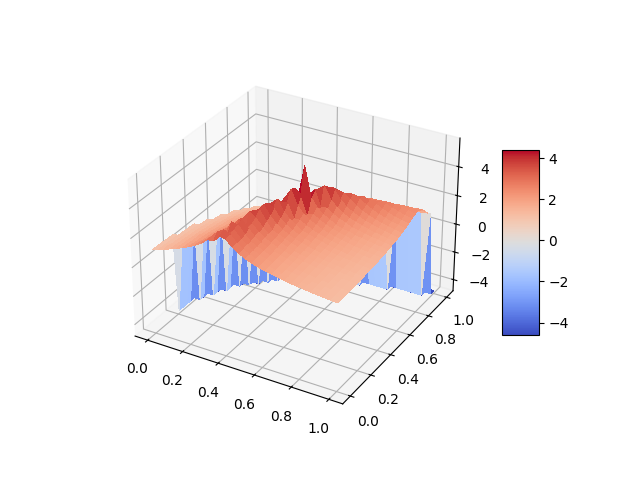

In [9]:
fig3d, ax3d = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax3d.plot_surface(X1, X2, Y, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig3d.colorbar(surf, shrink=0.5, aspect=5)

In [10]:
# run BO, ensure traget observables in config match the ones generated in this notebook
infer_from_config("input/ensembles/example.infer.toml")

Source for initial guess: sampling parameter space
    nsamp = 2
Initial sampling took 8.44s
Generated initial dataset with 2 points in 2-dim space
 
Starting optimisation with 3 workers and 2 initial samples
Performing 20 BO steps for a final total 22 samples
Step    1, best objective = 2.14162
Step    2, best objective = 2.33263
Step    3, best objective = 2.72181
Step    4, best objective = 2.72181
Step    5, best objective = 2.72181
Step    6, best objective = 3.12946
Step    7, best objective = 3.12946
Step    8, best objective = 3.12946
Step    9, best objective = 3.12946
Step   10, best objective = 3.12946
Step   11, best objective = 3.12946
Step   12, best objective = 3.12946
Step   13, best objective = 3.12946
Step   14, best objective = 3.12946
Step   15, best objective = 4.91419
Step   16, best objective = 4.91419
Step   17, best objective = 4.91419
Step   18, best objective = 4.91419
Worker 002 exiting
Step   19, best objective = 4.91419
Worker 001 exiting
Step   20, best o

In [11]:
path = "output/infer_demo/data.pkl"

with open(path, "rb") as f:
    D = pickle.load(f)

sampled_X = D["X"]
sampled_Y = D["Y"]

print("best sampled objective value: ",sampled_Y.max().item())

best_X = sampled_X[sampled_Y.argmax()][None,:]

path = "output/infer_demo/init.pkl"

with open(path, "rb") as f:
    D_init = pickle.load(f)

init_X = D_init["X"]

best sampled objective value:  4.914192889903199


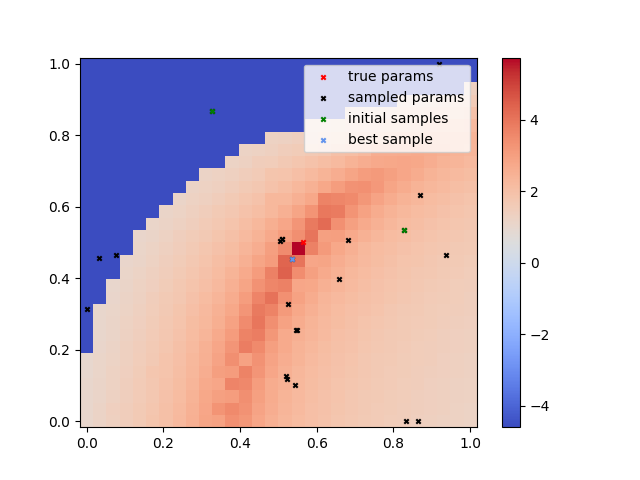

In [12]:
fig2d, ax2d = plt.subplots()
mesh = ax2d.pcolormesh(X1, X2, Y, shading="auto", cmap=cm.coolwarm)
fig2d.colorbar(mesh, ax=ax2d)
ax2d.scatter(true_x_norm[:, 0], true_x_norm[:, 1], marker="x", s=10, color = "red", label = "true params")
ax2d.scatter(sampled_X[:, 0], sampled_X[:, 1], marker="x", s=10, color= "black", label = "sampled params")
ax2d.scatter(init_X[:, 0], init_X[:, 1], marker="x", s=10, color= "green", label = "initial samples")
ax2d.scatter(best_X[:, 0], best_X[:, 1], marker="x", s=10, color= "cornflowerblue", label = "best sample")
ax2d.legend()